Fixed Basis Expantion is a technique to transform a 1D input into a higher-dimensional feature space, allowing what was originally non-linear to be fitted using a linear model.

There are different ways to transform the input, but the most simple way is known as a Polynominal Regression. Here the input $x$ is expanded by a defined number of degrees $d$.


$
[1, x, x^2, x^3, \dots, x^d]
$

Where $x$ = 2 and $d$ = 4 the the new expanded feature vector would be $[1, 2, 4, 8, 16]$


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

###Polynominal Regression

In [ ]:
def polynominal_basis(X, y, degree):
    # create design matrix
    phi = np.ones((X.shape[0], degree + 1))
    # for each column aka dimension
    for d in range(1, degree +1):
        # expand to corresponding power
        phi[:, d] = X ** d
    # OLS formula - closed form so no GD needed to find optimal weights
    w = np.linalg.inv(phi.T @ phi) @ phi.T @ y
    return w

def predict_polynominal_reg(X, w, degree):
    phi = np.ones((X.shape[0], degree + 1))
    for d in range(1, degree +1):
        phi[:, d] = X ** d
    # predict with learned weights
    y_hat = phi @ w
    return y_hat

The question arises of how many expansions we should use. To answer this we simply find the dimension where our loss is reduced the most. By using cross-validation we can measure this loss robustly by simulating learning the weights and then validating them on unseen data.

In [ ]:
# first assign data to their 'folds' which will be used to either train or validate
def kFold(X, k):
    n = X.shape[0]
    fold_size = n // k
    # if data length is not even get the remainder
    remainder = n % k
    indices = np.arange(n)
    np.random.shuffle(indices)

    for i in range(k):
        # start index
        start = i * fold_size + min(i, remainder)
        # end index
        end = (i + 1) * fold_size + min(i + 1, remainder)
        val_idx = indices[start:end]
        # training indicies are all minus validation
        train_idx = np.delete(indices, np.arange(start, end))

        yield train_idx, val_idx

# test dgrees on training and validation folds
def opt_poly_degree(X, y, degree_set):
    mean_losses = []
    std_losses = []
    for degree in degree_set:
        degree_losses = []
        # run cross validation K (5) times
        for train_idx, val_idx in kFold(X, 5):
            X_train, y_train = X[train_idx], y[train_idx]
            X_val, y_val = X[val_idx], y[val_idx]
            w = polynominal_basis(X_train, y_train, degree)
            y_pred = predict_polynominal_reg(X_val, w, degree)
            # loss = Mean Squared Error
            MSE = (y_val - y_pred)**2
            degree_losses.append(MSE)
        # get mean across each loop
        mean_losses.append(np.mean(degree_losses))
        std_losses.append(np.std(degree_losses))
    # return degree with lowest mean loss
    return degree_set[np.argmin(mean_losses)], mean_losses, std_losses

To see how Polynomial Regression works we will test it on some synthetic data. By plotting it visually we can tell that a standard Linear Regression would not predict very well.

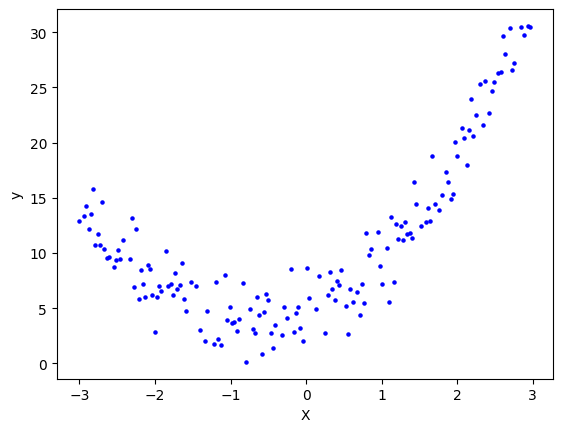

In [ ]:
X = np.linspace(-3, 3, 200)
y = 2*X**2 + 3*X + 5 + np.random.normal(0, 2, X.shape)

# split into test and training
np.random.seed(42)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

train_size = int(0.8 * X.shape[0])
train_idx = indices[:train_size]
test_idx = indices[train_size:]

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

plt.scatter(X_train, y_train, c='blue', s=5)
plt.xlabel("X")
plt.ylabel("y")
plt.show()

Degree Used: 3


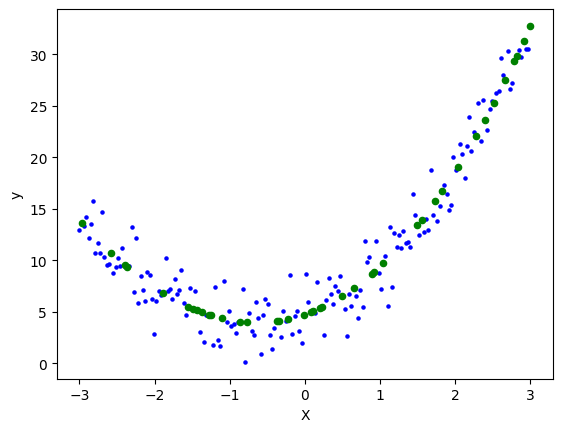

In [ ]:
# train
degree, _, _ = opt_poly_degree(X_train, y_train, range(1, 10))
print("Degree Used:", degree)
w_poly = polynominal_basis(X_train, y_train, degree)
# predict
y_hat_poly = predict_polynominal_reg(X_test, w_poly, degree)

plt.scatter(X_train, y_train,  c ="blue", s=5)
plt.scatter(X_test, y_hat_poly, c="green", s=20)
plt.xlabel("X")
plt.ylabel("y")
plt.show()


Let's test on a more complex distribution.

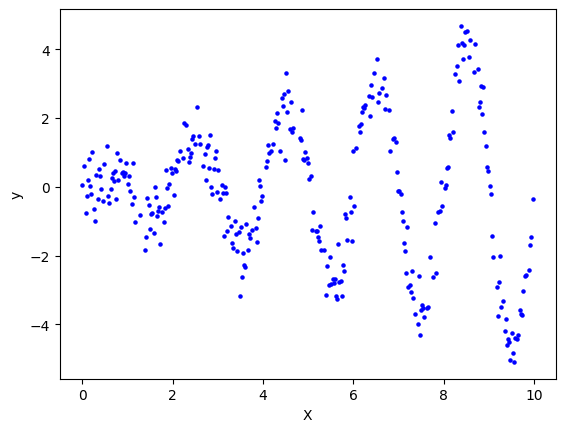

In [ ]:
# input
X = np.linspace(0, 10, 400)
y = (0.5 * X) * np.sin(2 * np.pi * X / 2) + np.random.normal(0, 0.5, X.shape)

# split into test and training
np.random.seed(42)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

train_size = int(0.8 * X.shape[0])
train_idx = indices[:train_size]
test_idx = indices[train_size:]

X_train_2, y_train_2 = X[train_idx], y[train_idx]
X_test_2, y_test_2 = X[test_idx], y[test_idx]

plt.scatter(X_train_2, y_train_2, c='blue',s=5)
plt.xlabel("X")
plt.ylabel("y")
plt.show()

Degree Used: 9


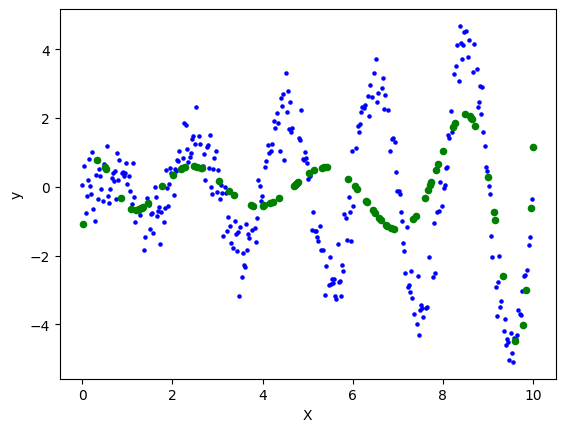

In [ ]:
# train
degree, _, _ = opt_poly_degree(X_train_2, y_train_2, range(1, 10))
print("Degree Used:", degree)
w_poly = polynominal_basis(X_train_2, y_train_2, degree)
# predict
y_hat_poly = predict_polynominal_reg(X_test_2, w_poly, degree)

plt.scatter(X_train_2, y_train_2,  c ="blue", s=5)
plt.scatter(X_test_2, y_hat_poly, c="green", s=20)
plt.xlabel("X")
plt.ylabel("y")
plt.show()


###Location Based Expantions - Radial Basis function (rbf)

As you can see Polynominal has struggled with the complexitity, thus a different expansion may be better suited. Many expansion functions are location based, this means that unlike Polynominal Regression where all points are transformed, only points near that defined location are transformed.

One such function is the radial basis function (rbf).

$$\phi(x; \mu, s) = \exp\left \{- \frac{(x-\mu)^2}{2s} \right \}$$

$x$ = the input

$\mu$ = centre of the basis function

$s$ = the spread; how quickly the influence of $mu$ decays as you move away from it.

In english: tranformation locations are selected. The influence of the transformation on data points diminishes as they are further away from the centres.


In [ ]:
# function
def phi_rbf(x, mu, s):
    return np.exp(-((x - mu)**2/2*s))

# find weights
def fixed_basis_rbf_reg(X, y, mus, s):
    # design matrix
    phi = np.ones((X.shape[0], len(mus)+1))
    for i in range(len(mus)):
        phi[:, i+1] = phi_rbf(X, mus[i], s)
    # fit design matrix - Normal Equation
    w = np.linalg.pinv(phi.T @ phi) @ phi.T @ y
    return w

def predict_rbf_reg(X, w, mus, s):
    # design matrix
    phi = np.ones((X.shape[0], len(mus)+1))
    for i in range(len(mus)):
        phi[:, i+1] = phi_rbf(X, mus[i], s)
    y_hat = phi @ w
    return y_hat

There are different ways to select the transformation centres, but in this notebook I will simply select evenly spaced points along the x-axis. We can see that RBF is better suited to this problem than Polynominal Regression

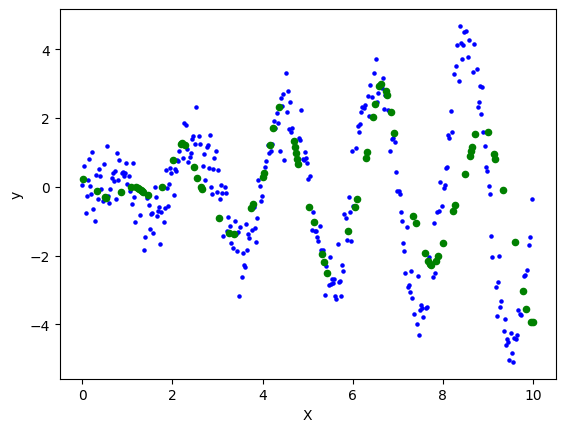

In [ ]:
k = 10
s = 15
mus_even = np.linspace(np.min(X_train_2), np.max(X_train_2), k)
w_even = fixed_basis_rbf_reg(X_train_2, y_train_2, mus_even, s)

y_hat_even = predict_rbf_reg(X_test_2, w_even, mus_even, s)

plt.scatter(X_train_2, y_train_2,  c ="blue", s=5)
plt.scatter(X_test_2, y_hat_even, c="green", s=20)
plt.xlabel("X")
plt.ylabel("y")
plt.show()